<a href="https://colab.research.google.com/github/aguilarafa2010/PLN/blob/main/Trabalho_Final_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bibliotecas

import pandas as pd
import numpy as np

import nltk
from nltk import tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import  model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

!conda install -c conda-forge spacy
!python -m spacy download pt_core_news_sm

import pt_core_news_sm

plt.rcParams["figure.figsize"] = [20,5]
sns.set_style("ticks")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/bin/bash: conda: command not found


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 21.2 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [2]:
# Leitura do arquivo
f = open("/content/sample_data/2000_Textos_Novo.txt","r")

#1) Criar um corpus com as instâncias de 2000_textos.txt, seguindo a seguinte estratégia:
O novo corpus terá instâncias rotuladas com uma das 3 classes
possíveis:
- classe “positivo”: instâncias da base original rotuladas como “alegria”;
- classe “negativo”: instâncias rotuladas como “raiva”, “medo”,
“desgosto” e “tristeza”;
- classe “neutro”: instâncias da base original rotuladas como “neutro”.
As instâncias rotuladas como “surpresa” não serão utilizadas neste
novo corpus. 

In [3]:
# Métodos e funções

def mudaClasse(x):
  if 'positivo' in x[1]:
    x[1] = 'positivo'
  elif 'neutro' in x[1]:
    x[1] = 'neutro'
  elif 'negativo' in x[1]:
    x[1] = 'negativo'

  return x

In [4]:
arquivo = []
for i in f:
  aux = i.split(';')
  arquivo.append([aux[0],aux[1]])

arquivo = [mudaClasse(x) for x in arquivo]

df = pd.DataFrame(arquivo)
df.columns = ['Texto', 'Classe']
df

,Texto,Classe
0,"irã liberta viúva condenada ao apedrejamento, ...",positivo
1,haiti sofre com cólera depois da passagem do f...,negativo
2,enchentes causam a morte de 4 pessoas em al: v...,negativo
3,"sem detalhes do que será discutido, revisão do...",neutro
4,chávez apresenta neto de allende como companhe...,neutro
...,...,...
1742,crise econômica agrava situação dos direitos h...,negativo
1743,reforma tributária ‘é o frankenstein do franke...,negativo
1744,"pernambuco tem apenas 2,5% da área original de...",negativo
1745,veja as principais notícias de abril: oms elev...,negativo


In [5]:
df = df.drop(df[df.Classe == 'surpresa'].index)

classes = df['Classe']
classes.unique()

array(['positivo', 'negativo', 'neutro'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 0 to 1746
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   1747 non-null   object
 1   Classe  1747 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB


#2) Plote a nova distribuição das classes.

In [7]:
grupos = df.groupby('Classe')
grupos.describe()

Texto                                                               
         count unique                                                top freq
Classe                                                                       
negativo  1021   1021  trabalhadores da limpeza pública podem entrar ...    1
neutro     542    542  atlético bate lanterna em lima e alcança líder...    1
positivo   184    184  irmãs se encontram após 72 anos graças ao face...    1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


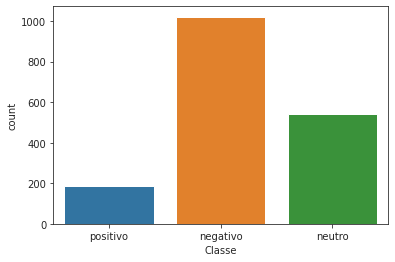

In [8]:
sns.countplot(df.Classe)

#3) Treine ao menos 3 classificadores que você achar mais apropriado para o problema:

Utilize a validação cruzada com 10-folds.

In [9]:
# Tokenização das palavras
# palavras_tokenize = []
contador = []
vetores = []
stop_words = set(stopwords.words('portuguese'))
nlp = pt_core_news_sm.load()
for index, row in df.iterrows():
  palavras = tokenize.word_tokenize(row.Texto, language='portuguese')
  palavras_tokenize = [word.lower() for word in palavras if word.isalpha() and word not in stop_words]

  texto = " ".join(palavras_tokenize)
  doc = nlp(texto)

  aux = ""

  for token in doc:
    aux += f" {token.lemma_}"

  df.at[index, 'Texto_Atualizado'] = aux
  vetores.append(nlp(aux).vector)

  contador.append(Counter(palavras))

df.head()

,Texto,Classe,Texto_Atualizado
0,"irã liberta viúva condenada ao apedrejamento, ...",positivo,irã liberto viúvo condenar apedrejamento dize...
1,haiti sofre com cólera depois da passagem do f...,negativo,haiti sofrer cólera passagem furacão sandy ap...
2,enchentes causam a morte de 4 pessoas em al: v...,negativo,enchente causar morte pessoa al vítima mãe fi...
3,"sem detalhes do que será discutido, revisão do...",neutro,detalhe discutir revisão planar diretor comed...
4,chávez apresenta neto de allende como companhe...,neutro,chávez apresentar neto allende companheiro fi...


In [10]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df.Texto_Atualizado)
vectors.shape

(1747, 6249)

In [11]:
# Prepara as classes

def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

positivo    1021
negativo    1021
neutro      1021
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


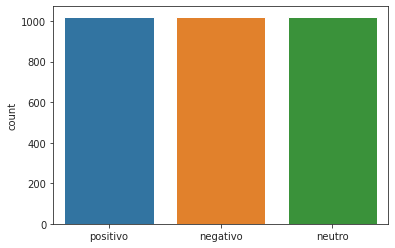

In [12]:
# Usando técnica de overSampling para ajustar a quantidade de dados
rus = RandomOverSampler()
X_res, y_res = rus.fit_sample(vectors, df.Classe)
 
# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())
 
# plotar a nova distribuição de classes
sns.countplot(y_res);

In [13]:
# Separando os dados em Treinamento e Teste

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size=0.3, random_state=1)

y_train, y_test = prepare_targets(y_train, y_test)

# Para uso da Validação Cruzada

folds=10
y = np.concatenate([y_train, y_test])
X = np.concatenate([X_train.toarray(), X_test.toarray()])

In [14]:
# TREINANDO MODELO SVM
# Prepara os dados de saída

# Create the LinearSVC model
clf_a = LinearSVC(random_state=1, dual=False)
# Fit the model
clf_a.fit(X_train, y_train)

print(f'Model test accuracy: {clf_a.score(X_test, y_test)*100:.3f}%')

# Avaliando o modelo
yhat_a = clf_a.predict(X_test)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
res_a = LinearSVC(random_state=1, dual=False)

result_a = model_selection.cross_val_score(res_a, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
mean = result_a.mean()*100
print("Mean Accuracy: %.3f" % mean)
print("Mean Std: %.3f" % result_a.std())

Z_a = model_selection.cross_val_predict(res_a, X, y, cv=folds)

Model test accuracy: 89.010%

Cross Validation Results 10 folds:
Mean Accuracy: 91.577
Mean Std: 0.017


In [15]:
# MODELO LOGISTIC REGRESSION

# Declara o classificador
clf_b = LogisticRegression()

# Treina o classificador
clf_b = clf_b.fit(X_train, y_train)
print(f'Model test accuracy: {clf_b.score(X_test, y_test)*100:.3f}%')

# Testa usando a base de testes
yhat_b = clf_b.predict(X_test)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
res_b = LogisticRegression()

Z_b = model_selection.cross_val_predict(res_b, X, y, cv=folds)

result_b = model_selection.cross_val_score(res_b, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
mean = result_b.mean()*100
print("Mean Accuracy: %.3f" % mean)
print("Mean Std: %.3f" % result_b.std())

Model test accuracy: 89.227%

Cross Validation Results 10 folds:
Mean Accuracy: 91.871
Mean Std: 0.021


In [16]:
# MODELO NAIVE BAYES

# Treina o classificador
clf_c = GaussianNB()
clf_c = clf_c.fit(X_train.toarray(), y_train)

# Calcula a acurácia na base de teste
score=clf_c.score(X_test.toarray(), y_test)
print(f'Model test accuracy: {clf_c.score(X_test.toarray(), y_test)*100:.3f}%')

# Testa usando a base de testes
yhat_c = clf_c.predict(X_test.toarray())

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
res_c = GaussianNB()

Z_c = model_selection.cross_val_predict(res_c, X, y, cv=folds)

result_c = model_selection.cross_val_score(res_c, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
mean = result_c.mean()*100
print("Mean Accuracy: %.3f" % mean)
print("Mean Std: %.3f" % result_c.std())

Model test accuracy: 88.139%

Cross Validation Results 10 folds:
Mean Accuracy: 89.814
Mean Std: 0.018


# 4) Gere a matriz de confusão e calcule: cobertura, precisão e medida-f.

In [17]:
recall_a = recall_score(y, Z_a, average='weighted')
recall_b = recall_score(y, Z_b, average='weighted')
recall_c = recall_score(y, Z_c, average='weighted')

print('Recall: %.3f' % recall_a)
print('Recall: %.3f' % recall_b)
print('Recall: %.3f' % recall_c)

Recall: 0.916
Recall: 0.919
Recall: 0.898


In [18]:
precision_a = precision_score(y, Z_a, average='weighted')
precision_b = precision_score(y, Z_b, average='weighted')
precision_c = precision_score(y, Z_c, average='weighted')

print('Precision: %.3f' % precision_a)
print('Precision: %.3f' % precision_b)
print('Precision: %.3f' % precision_c)

Precision: 0.915
Precision: 0.919
Precision: 0.900


In [19]:

score_a = f1_score(y, Z_a, average='weighted')
score_b = f1_score(y, Z_b, average='weighted')
score_c = f1_score(y, Z_c, average='weighted')

print('F-Measure: %.3f' % score_a)
print('F-Measure: %.3f' % score_b)
print('F-Measure: %.3f' % score_c)

F-Measure: 0.915
F-Measure: 0.918
F-Measure: 0.897


#5) Plote a matriz de confusão e imprima a cobertura, precisão e medida-f para cada classe.

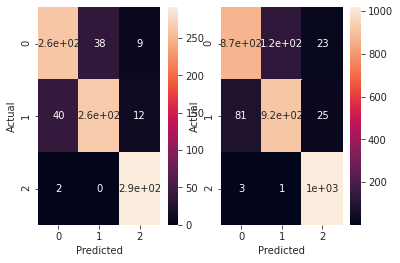

In [20]:
confusion_matrix_1 = pd.crosstab(y_test, yhat_a, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_2 = pd.crosstab(y, Z_a, rownames=['Actual'], colnames=['Predicted'])

fig, ax =plt.subplots(1,2)
sns.heatmap(confusion_matrix_1, annot=True, ax=ax[0], )
sns.heatmap(confusion_matrix_2, annot=True, ax=ax[1] )

fig.show()

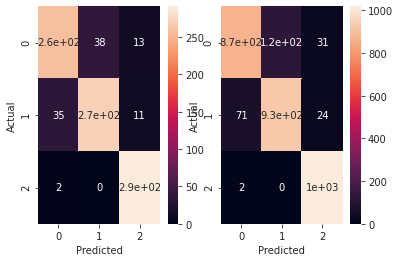

In [21]:
confusion_matrix_1 = pd.crosstab(y_test, yhat_b, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_2 = pd.crosstab(y, Z_b, rownames=['Actual'], colnames=['Predicted'])

fig, ax =plt.subplots(1,2)
sns.heatmap(confusion_matrix_1, annot=True, ax=ax[0])
sns.heatmap(confusion_matrix_2, annot=True, ax=ax[1] )

fig.show()

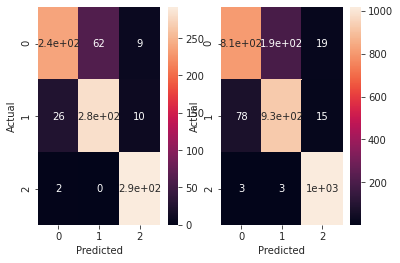

In [22]:
confusion_matrix_1 = pd.crosstab(y_test, yhat_c, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_2 = pd.crosstab(y, Z_c, rownames=['Actual'], colnames=['Predicted'])

fig, ax =plt.subplots(1,2)
sns.heatmap(confusion_matrix_1, annot=True, ax=ax[0])
sns.heatmap(confusion_matrix_2, annot=True, ax=ax[1] )

fig.show()

In [23]:
recall_classe_a = recall_score(y, Z_a, average=None)
print(recall_classe_a)

recall_classe_b = recall_score(y, Z_b, average=None)
print(recall_classe_b)

recall_classe_c = recall_score(y, Z_c, average=None)
print(recall_classe_c)

[0.85504407 0.89618022 0.99608227]
[0.85112635 0.90695397 0.99804114]
[0.791381   0.90891283 0.99412341]


In [24]:
precision_classe_a = precision_score(y, Z_a, average=None)
print(precision_classe_a)

precision_classe_b = precision_score(y, Z_b, average=None)
print(precision_classe_b)

precision_classe_c = precision_score(y, Z_c, average=None)
print(precision_classe_c)

[0.91222571 0.87896254 0.95492958]
[0.92250531 0.88443171 0.94878957]
[0.90888639 0.82488889 0.96758818]


In [25]:
score_classe_a = f1_score(y, Z_a, average=None)
print(score_classe_a)

score_classe_b = f1_score(y, Z_b, average=None)
print(score_classe_b)

score_classe_c = f1_score(y, Z_c, average=None)
print(score_classe_c)

[0.88270981 0.88748788 0.97507191]
[0.88537952 0.89555126 0.97279236]
[0.8460733  0.86486486 0.98067633]
